In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.applications import ResNet152V2
from keras.applications import MobileNetV2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import AdamW
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import precision_score

In [2]:
testDataset = image_dataset_from_directory(
    "/kaggle/input/ecgimages/test",
    image_size=(224, 224)
)

Found 448 files belonging to 4 classes.


In [3]:
trainDataset = image_dataset_from_directory(
    "/kaggle/input/ecgimages/train",
    image_size=(224, 224),
    validation_split=0.2,
    subset="training",
    seed=123
)

Found 928 files belonging to 4 classes.
Using 743 files for training.


In [4]:
validationDataset = image_dataset_from_directory(
    "/kaggle/input/ecgimages/train",
    image_size=(224, 224),
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 928 files belonging to 4 classes.
Using 185 files for validation.


In [5]:
for image_batch, labels_batch in validationDataset.take(1):
    print(image_batch.shape)

(32, 224, 224, 3)


<h3 style='color:purple'>Build convolutional neural network and train it</h3>

In [6]:
EPOCHS=1000
CALLBACKS=[ReduceLROnPlateau(patience=25),EarlyStopping(patience=50)]

In [7]:
model = MobileNetV2()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
model.compile(optimizer=AdamW(),
               loss=SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

In [10]:
model.fit(trainDataset, epochs=EPOCHS, callbacks=CALLBACKS, validation_data=validationDataset)

Epoch 1/1000
 1/24 ━━━━━━━━━━━━━━━━━━━━ 21:42 57s/step - accuracy: 0.0000e+00 - loss: 7.2114

I0000 00:00:1715457885.050487     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6042 - loss: 2.3444 - val_accuracy: 0.0649 - val_loss: 10.0280 - learning_rate: 0.0010
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9188 - loss: 0.2001 - val_accuracy: 0.2649 - val_loss: 13.5580 - learning_rate: 0.0010
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.9168 - loss: 0.2510 - val_accuracy: 0.2649 - val_loss: 30.2009 - learning_rate: 0.0010
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9546 - loss: 0.1345 - val_accuracy: 0.2649 - val_loss: 32.8080 - learning_rate: 0.0010
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9744 - loss: 0.0847 - val_accuracy: 0.2486 - val_loss: 7.1183 - learning_rate: 0.0010
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9626 - loss: 0.0840 - val_accuracy: 0.2649 - val_loss: 26.2006 - learning_rate: 0.0010
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9818 - loss: 0.063

In [11]:
scores = model.evaluate(testDataset)
scores

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9893 - loss: 0.0222


[0.02691301517188549, 0.9910714030265808]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


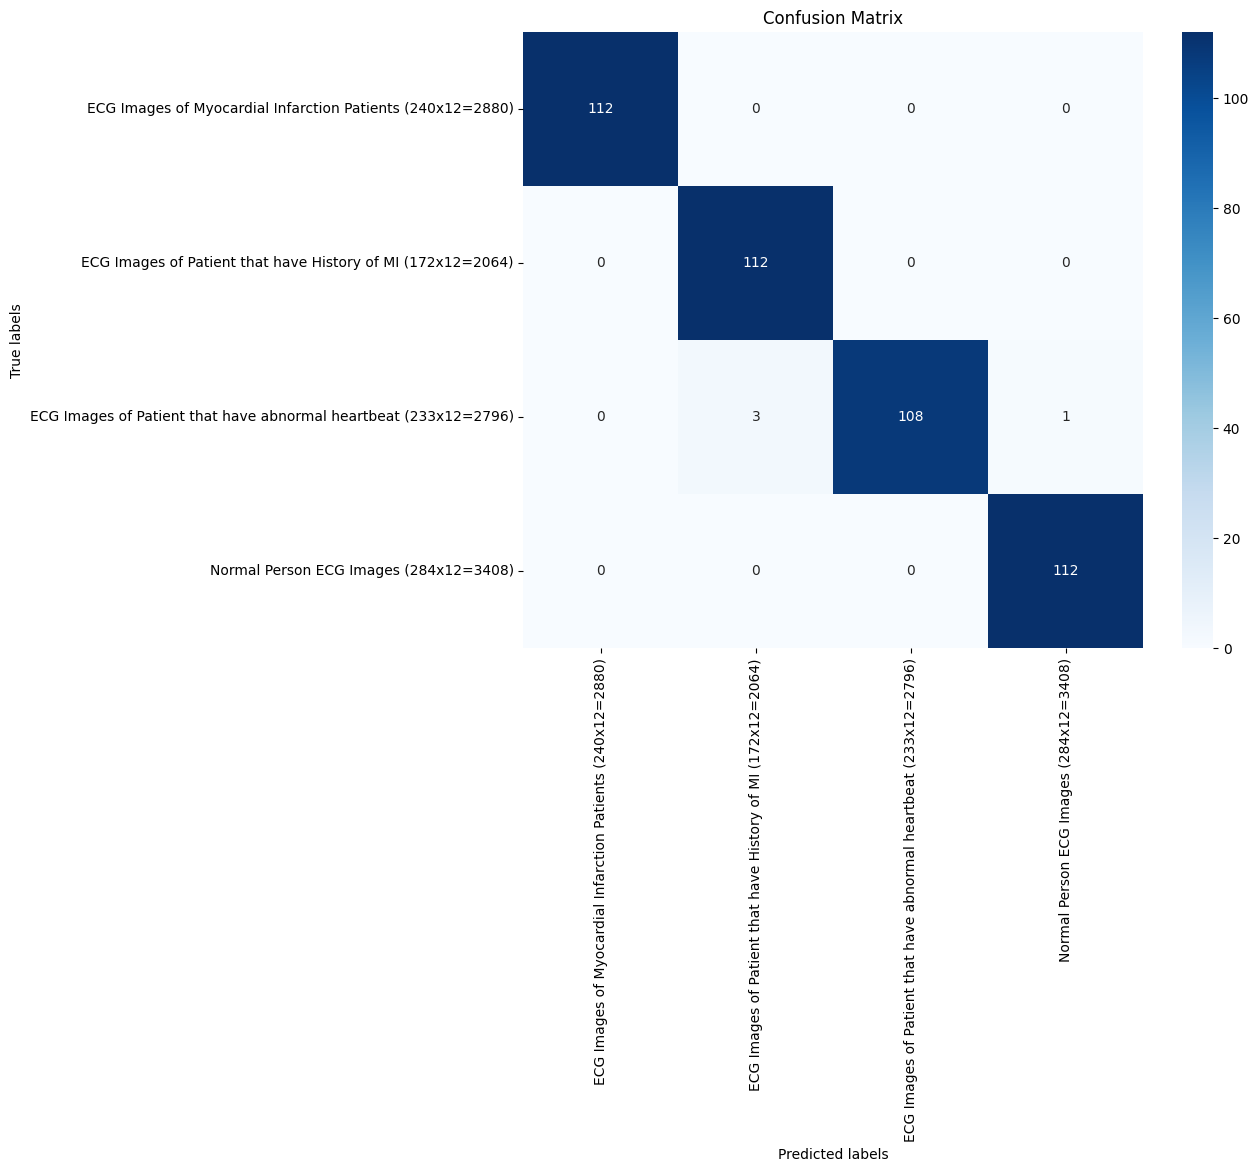

In [16]:
y_true = []
y_pred = []

for images, labels in testDataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=testDataset.class_names, yticklabels=testDataset.class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
print(classification_report(y_true, y_pred, target_names=testDataset.class_names))

                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       1.00      1.00      1.00       112
     ECG Images of Patient that have History of MI (172x12=2064)       0.97      1.00      0.99       112
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       1.00      0.96      0.98       112
                          Normal Person ECG Images (284x12=3408)       0.99      1.00      1.00       112

                                                        accuracy                           0.99       448
                                                       macro avg       0.99      0.99      0.99       448
                                                    weighted avg       0.99      0.99      0.99       448



In [18]:
model.save('/kaggle/working/MobileNet.h5')